### Ferdinand Beaman's Renovation Project <br>
Part time<br>
Scheduled project review date/time: Jul 14, 2023, 1:15pm <br>
Instructor: Mark Barbour<br>
Blog post URL: 


For this project, I am assessing the value of various homes in Seattle in an attempt to advise a renovation company what they should charge.

# Prepping the Data

In [100]:
#All the libraries I conceivably could use
import pandas as pd
import numpy as np
from scipy import stats #(for ttests etc)
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols #(for anova)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [101]:
#Importing the data and dropping unnecessary columns
base_df = pd.read_csv("data/kc_house_data.csv")
base_df.drop(["view", "date", "sqft_above", "sqft_basement", "yr_renovated", 
              "address","lat", "long"], axis = 1, inplace = True)

In [102]:
base_df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,condition,grade,heat_source,sewer_system,sqft_garage,sqft_patio,yr_built
0,7399300360,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,Good,7 Average,Gas,PUBLIC,0,40,1969
1,8910500230,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,Average,7 Average,Oil,PUBLIC,0,240,1950
2,1180000275,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,Average,7 Average,Gas,PUBLIC,0,0,1956
3,1604601802,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,Average,9 Better,Gas,PUBLIC,200,270,2010
4,8562780790,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,Average,7 Average,Electricity,PUBLIC,550,30,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,1555000.0,5,2.0,1910,4000,1.5,NO,NO,NO,Good,8 Good,Oil,PUBLIC,0,210,1921
30151,194000695,1313000.0,3,2.0,2020,5800,2.0,NO,NO,NO,Average,7 Average,Gas,PUBLIC,0,520,2011
30152,7960100080,800000.0,3,2.0,1620,3600,1.0,NO,NO,YES,Average,7 Average,Gas,PUBLIC,240,110,1995
30153,2781280080,775000.0,3,2.5,2570,2889,2.0,NO,NO,NO,Average,8 Good,Gas,PUBLIC,480,100,2006


## Exploration Phase

First on my agenda: looking at the categorical data.

In [103]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            30155 non-null  int64  
 1   price         30155 non-null  float64
 2   bedrooms      30155 non-null  int64  
 3   bathrooms     30155 non-null  float64
 4   sqft_living   30155 non-null  int64  
 5   sqft_lot      30155 non-null  int64  
 6   floors        30155 non-null  float64
 7   waterfront    30155 non-null  object 
 8   greenbelt     30155 non-null  object 
 9   nuisance      30155 non-null  object 
 10  condition     30155 non-null  object 
 11  grade         30155 non-null  object 
 12  heat_source   30123 non-null  object 
 13  sewer_system  30141 non-null  object 
 14  sqft_garage   30155 non-null  int64  
 15  sqft_patio    30155 non-null  int64  
 16  yr_built      30155 non-null  int64  
dtypes: float64(3), int64(7), object(7)
memory usage: 3.9+ MB


In [104]:
base_df.heat_source.value_counts()

Gas                  20583
Electricity           6465
Oil                   2899
Gas/Solar               93
Electricity/Solar       59
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64

In [105]:
base_df.grade.value_counts()

7 Average        11697
8 Good            9410
9 Better          3806
6 Low Average     2858
10 Very Good      1371
11 Excellent       406
5 Fair             393
12 Luxury          122
4 Low               51
13 Mansion          24
3 Poor              13
2 Substandard        2
1 Cabin              2
Name: grade, dtype: int64

In [106]:
base_df.condition.value_counts()

Average      18547
Good          8054
Very Good     3259
Fair           230
Poor            65
Name: condition, dtype: int64

In [107]:
base_df.sewer_system.value_counts()

PUBLIC                25777
PRIVATE                4355
PRIVATE RESTRICTED        6
PUBLIC RESTRICTED         3
Name: sewer_system, dtype: int64

## Cleaning the data

In [108]:
# Changing the "grade" to a number
base_df.grade = pd.to_numeric(base_df.grade.str.slice(stop=1))

In [109]:
# Changing the "condition" to a number
condition_dict = {"Poor":0, "Fair":1, "Average":2, "Good":3, "Very Good": 4}
base_df.replace({"condition":condition_dict}, inplace = True)

In [110]:
# Changing the three yes/no categories into 1/0
binary_dict = {"YES":1, "NO":0}
base_df.replace({"nuisance":binary_dict}, inplace = True)
base_df.replace({"greenbelt":binary_dict}, inplace = True)
base_df.replace({"waterfront":binary_dict}, inplace = True)
base_df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,condition,grade,heat_source,sewer_system,sqft_garage,sqft_patio,yr_built
0,7399300360,675000.0,4,1.0,1180,7140,1.0,0,0,0,3,7,Gas,PUBLIC,0,40,1969
1,8910500230,920000.0,5,2.5,2770,6703,1.0,0,0,1,2,7,Oil,PUBLIC,0,240,1950
2,1180000275,311000.0,6,2.0,2880,6156,1.0,0,0,0,2,7,Gas,PUBLIC,0,0,1956
3,1604601802,775000.0,3,3.0,2160,1400,2.0,0,0,0,2,9,Gas,PUBLIC,200,270,2010
4,8562780790,592500.0,2,2.0,1120,758,2.0,0,0,1,2,7,Electricity,PUBLIC,550,30,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,1555000.0,5,2.0,1910,4000,1.5,0,0,0,3,8,Oil,PUBLIC,0,210,1921
30151,194000695,1313000.0,3,2.0,2020,5800,2.0,0,0,0,2,7,Gas,PUBLIC,0,520,2011
30152,7960100080,800000.0,3,2.0,1620,3600,1.0,0,0,1,2,7,Gas,PUBLIC,240,110,1995
30153,2781280080,775000.0,3,2.5,2570,2889,2.0,0,0,0,2,8,Gas,PUBLIC,480,100,2006


In [111]:
#deleting rows with nans
nan_count = base_df.isna().sum()
nan_count

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
greenbelt        0
nuisance         0
condition        0
grade            0
heat_source     32
sewer_system    14
sqft_garage      0
sqft_patio       0
yr_built         0
dtype: int64

In [112]:
base_df.dropna(axis=0, subset=["sewer_system", "heat_source"], inplace=True)

In [113]:
#One-hot encoding the categorical data columns
df = pd.get_dummies(base_df, columns=["heat_source", "sewer_system"], drop_first=True)
df.drop("id", axis = 1, inplace = True)
df.reset_index(inplace=True)

In [114]:
# Identifying the outliers for removal
df.price.describe()

count    3.011100e+04
mean     1.108971e+06
std      8.965158e+05
min      2.736000e+04
25%      6.492360e+05
50%      8.600000e+05
75%      1.300000e+06
max      3.075000e+07
Name: price, dtype: float64

In [115]:
#Q3 - Q1
1300000 - 649236

650764

In [116]:
#The lower bound isn't necessary to calculate, since it would be negative
upper = 1300000 + (1300000 - 649236) #The upper bound
df = df[df["price"] < upper].copy()
df

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,yr_built,heat_source_Electricity/Solar,heat_source_Gas,heat_source_Gas/Solar,heat_source_Oil,heat_source_Oil/Solar,heat_source_Other,sewer_system_PRIVATE RESTRICTED,sewer_system_PUBLIC,sewer_system_PUBLIC RESTRICTED
0,0,675000.0,4,1.0,1180,7140,1.0,0,0,0,...,1969,0,1,0,0,0,0,0,1,0
1,1,920000.0,5,2.5,2770,6703,1.0,0,0,1,...,1950,0,0,0,1,0,0,0,1,0
2,2,311000.0,6,2.0,2880,6156,1.0,0,0,0,...,1956,0,1,0,0,0,0,0,1,0
3,3,775000.0,3,3.0,2160,1400,2.0,0,0,0,...,2010,0,1,0,0,0,0,0,1,0
4,4,592500.0,2,2.0,1120,758,2.0,0,0,1,...,2012,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30106,30150,1555000.0,5,2.0,1910,4000,1.5,0,0,0,...,1921,0,0,0,1,0,0,0,1,0
30107,30151,1313000.0,3,2.0,2020,5800,2.0,0,0,0,...,2011,0,1,0,0,0,0,0,1,0
30108,30152,800000.0,3,2.0,1620,3600,1.0,0,0,1,...,1995,0,1,0,0,0,0,0,1,0
30109,30153,775000.0,3,2.5,2570,2889,2.0,0,0,0,...,2006,0,1,0,0,0,0,0,1,0


In [117]:
#What fraction of my data do I have left?
len(df)/len(base_df)

0.9040549965129022

## Visualizing the basics

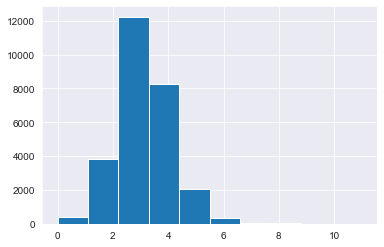

In [118]:
plt.hist(df.bedrooms);

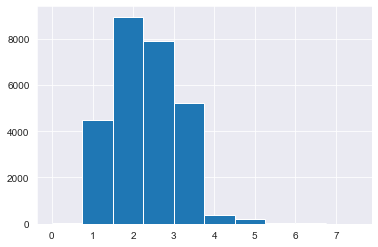

In [119]:
plt.hist(df.bathrooms);

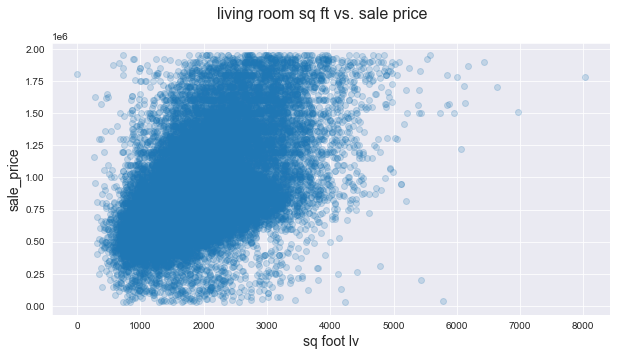

In [120]:
#Living room vs Sale Price
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('living room sq ft vs. sale price', fontsize=16)
ax.scatter(df.sqft_living, df.price, alpha = .2)
ax.set_xlabel('sq foot lv', fontsize=14)
ax.set_ylabel('sale_price', fontsize=14);

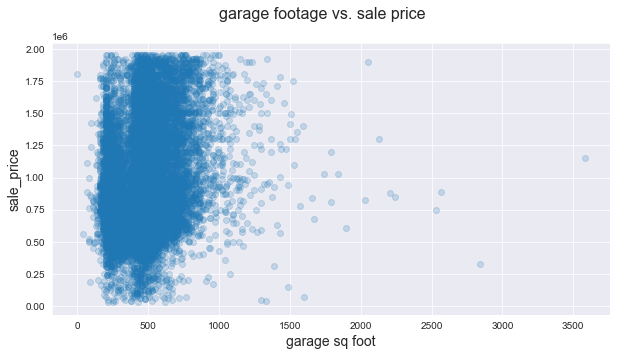

In [121]:
#Garage vs Sale Price
df_has_garage = df[df.sqft_garage > 0].copy()
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('garage footage vs. sale price', fontsize=16)
ax.scatter(df_has_garage.sqft_garage, df_has_garage.price, alpha = .2)
ax.set_xlabel('garage sq foot', fontsize=14)
ax.set_ylabel('sale_price', fontsize=14);

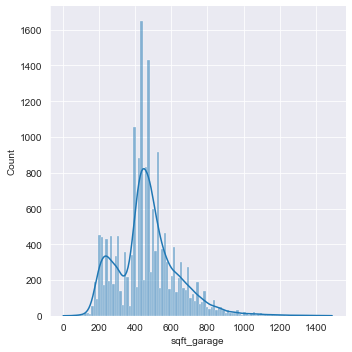

In [122]:
#I wonder why garages seem to be bimodal
sns.displot(df_has_garage[df_has_garage.sqft_garage<1500].sqft_garage, kde=True);

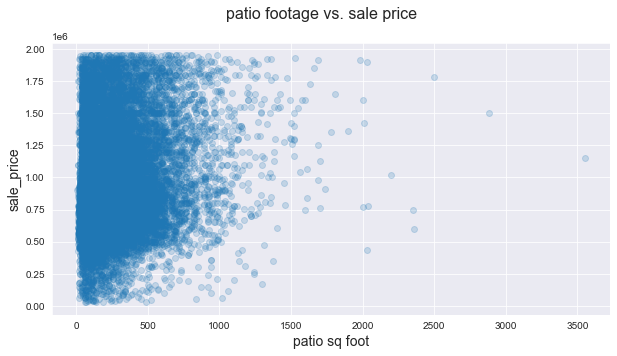

In [123]:
#Patio vs Sale Price
df_has_patio = df[df.sqft_patio>0].copy()
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('patio footage vs. sale price', fontsize=16)
ax.scatter(df_has_patio.sqft_patio, df_has_patio.price, alpha = .2)
ax.set_xlabel('patio sq foot', fontsize=14)
ax.set_ylabel('sale_price', fontsize=14);

The top of all of my scatterplots look like they have been chopped off prematurely. I lost about 10% of my data when I removed the outliers. So maybe I should remove the outliers by keeping only data from the middle two standard deviations? If my data is close to normal, then I should only lose about 5% of my data that way.

In [124]:
#Finding the upper and lower bounds
print("new lower", base_df.price.mean()-(base_df.price.std()*2))
print("new upper", base_df.price.mean()+(base_df.price.std()*2))

new lower -684061.0086032962
new upper 2902002.311847958


There isn't a new lower bound, but the new upper bound is quite a bit higher. About a million dollars, by the looks of it.

In [125]:
2902002.311847958 - upper #"upper" is my previous upper bound using IQR

951238.3118479578

In [126]:
#Redoing the things I did after renaming base_df before removing outliers

df = pd.get_dummies(base_df, columns=["heat_source", 
                                      "sewer_system"], drop_first=True)
df.drop("id", axis = 1, inplace = True)
df.reset_index(inplace=True)

#Setting new upper bound
df = df[df["price"] < 2902002.31].copy()
df

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,yr_built,heat_source_Electricity/Solar,heat_source_Gas,heat_source_Gas/Solar,heat_source_Oil,heat_source_Oil/Solar,heat_source_Other,sewer_system_PRIVATE RESTRICTED,sewer_system_PUBLIC,sewer_system_PUBLIC RESTRICTED
0,0,675000.0,4,1.0,1180,7140,1.0,0,0,0,...,1969,0,1,0,0,0,0,0,1,0
1,1,920000.0,5,2.5,2770,6703,1.0,0,0,1,...,1950,0,0,0,1,0,0,0,1,0
2,2,311000.0,6,2.0,2880,6156,1.0,0,0,0,...,1956,0,1,0,0,0,0,0,1,0
3,3,775000.0,3,3.0,2160,1400,2.0,0,0,0,...,2010,0,1,0,0,0,0,0,1,0
4,4,592500.0,2,2.0,1120,758,2.0,0,0,1,...,2012,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30106,30150,1555000.0,5,2.0,1910,4000,1.5,0,0,0,...,1921,0,0,0,1,0,0,0,1,0
30107,30151,1313000.0,3,2.0,2020,5800,2.0,0,0,0,...,2011,0,1,0,0,0,0,0,1,0
30108,30152,800000.0,3,2.0,1620,3600,1.0,0,0,1,...,1995,0,1,0,0,0,0,0,1,0
30109,30153,775000.0,3,2.5,2570,2889,2.0,0,0,0,...,2006,0,1,0,0,0,0,0,1,0


In [127]:
#What fraction of my data do I have now?
len(df)/len(base_df)

0.9686161203546877

Another 5% or so. Okay. Now I'll revisit those charts from before to see if they look any better.

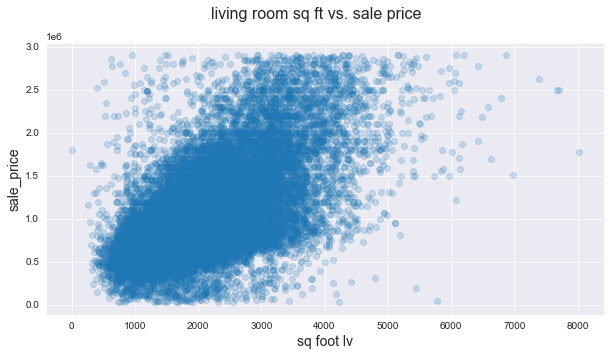

In [128]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('living room sq ft vs. sale price', fontsize=16)
ax.scatter(df.sqft_living, df.price, alpha = .2)
ax.set_xlabel('sq foot lv', fontsize=14)
ax.set_ylabel('sale_price', fontsize=14);

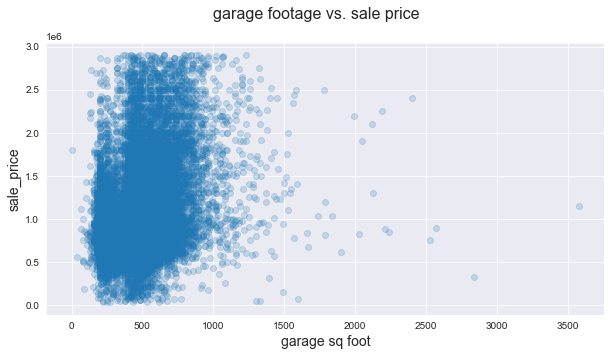

In [129]:
df_has_garage = df[df.sqft_garage > 0].copy() #df of houses with garages
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('garage footage vs. sale price', fontsize=16)
ax.scatter(df_has_garage.sqft_garage, df_has_garage.price, alpha = .2)
ax.set_xlabel('garage sq foot', fontsize=14)
ax.set_ylabel('sale_price', fontsize=14);

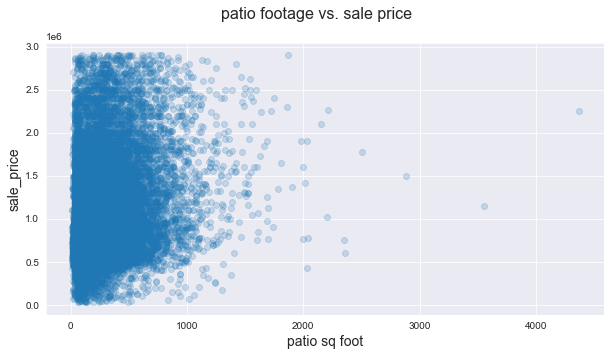

In [130]:
df_has_patio = df[df.sqft_patio>0].copy() #df of houses with patios
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('patio footage vs. sale price', fontsize=16)
ax.scatter(df_has_patio.sqft_patio, df_has_patio.price, alpha = .2)
ax.set_xlabel('patio sq foot', fontsize=14)
ax.set_ylabel('sale_price', fontsize=14);

Not perfect, but quite a bit better.

I'll include the existence of a patio/garage at all as their own columns

In [131]:
df.loc[df.sqft_garage > 0, "garage"] = 1
df.loc[df.sqft_garage == 0, "garage"] = 0

df.loc[df.sqft_patio > 0, "patio"] = 1
df.loc[df.sqft_patio == 0, "patio"] = 0

Okay, so now that everything is set up, let's see what features correlate significantly with price.

# Stats

### Basic OLS
We're just looking at each variable individually.

In [132]:
features = "bedrooms bathrooms sqft_living patio garage condition grade".split()
y = df["price"]
for feat in features:
    X_baseline = df[[feat]]
    baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
    baseline_results = baseline_model.fit()
    print(feat)
    print(baseline_results.summary())
    print("\n")
    print("\n")

#
X_baseline = df_has_garage[["sqft_garage"]]
y = df_has_garage["price"]
baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()
print("garage size")
print(baseline_results.summary())
print("\n")
print("\n")

y = df_has_patio["price"]
X_baseline = df_has_patio[["sqft_patio"]]
baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()
print("patio size")
print(baseline_results.summary())

bedrooms
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     3755.
Date:                Fri, 14 Jul 2023   Prob (F-statistic):               0.00
Time:                        12:51:24   Log-Likelihood:            -4.2361e+05
No. Observations:               29166   AIC:                         8.472e+05
Df Residuals:                   29164   BIC:                         8.472e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.792e+05   1.05e+04     36.024

Woah, so grade and condition barely matter? I'll come back to that later.

Bathrooms seem to be accounting for 300,000 dollar's worth of value, but they might be unweildy to add to a home. I will hold onto that if I need to, but for now let's look at the log transformations.

### Log Transformations
Just checking to see if this has a positive effect.

In [133]:
#Can't take the log of anything with 0 as a value
df_log = df[df["bathrooms"] > 0].copy()
df_log = df_log[df_log["bedrooms"] > 0].copy()
df_log["condition"] = df_log["condition"] +1

features = "bedrooms bathrooms sqft_living condition grade".split()
y = df_log["price"]
for feat in features:
    X_baseline = np.log(df_log[[feat]])
    baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
    baseline_results = baseline_model.fit()
    print("log ", feat)
    print(baseline_results.summary())
    print("\n")
    print("\n")

X_baseline = np.log(df_has_garage[["sqft_garage"]])
y = df_has_garage["price"]
baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()
print("log garage size")
print(baseline_results.summary())
print("\n")
print("\n")

y = df_has_patio["price"]
X_baseline = np.log(df_has_patio[["sqft_patio"]])
baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()
print("log patio size")
print(baseline_results.summary())

log  bedrooms
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     3531.
Date:                Fri, 14 Jul 2023   Prob (F-statistic):               0.00
Time:                        12:51:24   Log-Likelihood:            -4.2309e+05
No. Observations:               29124   AIC:                         8.462e+05
Df Residuals:                   29122   BIC:                         8.462e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.241e+05   1.17e+04     2

Conveniently, none of the features were more accurately predictive when log transformed. Well, condition went from an rsquared of 0 to 0.001, so there's that.

## Multivariable OLS

In [134]:
df.columns

Index(['index', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'greenbelt', 'nuisance', 'condition', 'grade',
       'sqft_garage', 'sqft_patio', 'yr_built',
       'heat_source_Electricity/Solar', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'heat_source_Oil/Solar',
       'heat_source_Other', 'sewer_system_PRIVATE RESTRICTED',
       'sewer_system_PUBLIC', 'sewer_system_PUBLIC RESTRICTED', 'garage',
       'patio'],
      dtype='object')

In [135]:
all_x = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'greenbelt', 'nuisance', 'condition', 'grade',
       'sqft_garage', 'sqft_patio', 'yr_built',
       'heat_source_Electricity/Solar', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'heat_source_Oil/Solar',
       'heat_source_Other', 'sewer_system_PRIVATE RESTRICTED',
       'sewer_system_PUBLIC', 'sewer_system_PUBLIC RESTRICTED']
y = df["price"]
all_model = sm.OLS(y, sm.add_constant(df[all_x]))
all_results = all_model.fit()
print(all_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     969.6
Date:                Fri, 14 Jul 2023   Prob (F-statistic):               0.00
Time:                        12:51:24   Log-Likelihood:            -4.1737e+05
No. Observations:               29166   AIC:                         8.348e+05
Df Residuals:                   29143   BIC:                         8.350e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Bathrooms lost a lot of perceived value when everything was taken together. We're down to about 73,000 dollars per bathroom.

There were a few features that had statistically insignificant values. Those features were predominantly ones with very small samples. Either way, let's recalculate the model without them.

In [136]:
all_x = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'greenbelt', 'nuisance', 'condition', 'grade',
       'sqft_garage', 'sqft_patio', 'yr_built', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'sewer_system_PUBLIC']
y = df["price"]
all_model = sm.OLS(y, sm.add_constant(df[all_x]))
all_results = all_model.fit()
print(all_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     1254.
Date:                Fri, 14 Jul 2023   Prob (F-statistic):               0.00
Time:                        12:51:24   Log-Likelihood:            -4.1737e+05
No. Observations:               29166   AIC:                         8.348e+05
Df Residuals:                   29148   BIC:                         8.349e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  5.258e+

I lost a point of explanatory power by doing that, but it's only a tiny amount.
#### The model is explaining 42.2% of the variability for price.
Building a patio, garage, new bedroom, new bathroom, and extended living room will affect the house's price. But will those prices be affected by other factors in the house?

# Testing Assumptions for Linear Regression

### Multicollinearity

In [137]:
data_pred = df[["price", "bedrooms", "bathrooms", "greenbelt", "nuisance", 
                "waterfront", "condition", "grade", "heat_source_Gas",
               "sewer_system_PUBLIC"]]
data_pred.corr()

,price,bedrooms,bathrooms,greenbelt,nuisance,waterfront,condition,grade,heat_source_Gas,sewer_system_PUBLIC
price,1.000000,0.337745,0.474533,0.114501,-0.019381,0.053918,0.021909,-0.090153,0.186523,0.020572
bedrooms,0.337745,1.000000,0.571455,0.065638,-0.053210,-0.053939,0.042258,0.053442,0.222307,0.033242
bathrooms,0.474533,0.571455,1.000000,0.096227,-0.060714,-0.006669,-0.057319,0.073074,0.269086,0.034733
greenbelt,0.114501,0.065638,0.096227,1.000000,-0.052575,-0.018075,-0.029180,-0.051461,0.089172,0.030089
nuisance,-0.019381,-0.053210,-0.060714,-0.052575,1.000000,-0.001472,-0.017809,-0.021380,-0.091014,0.003203
waterfront,0.053918,-0.053939,-0.006669,-0.018075,-0.001472,1.000000,0.005158,-0.039201,-0.066067,-0.151244
condition,0.021909,0.042258,-0.057319,-0.029180,-0.017809,0.005158,1.000000,-0.035073,0.018055,-0.094539
grade,-0.090153,0.053442,0.073074,-0.051461,-0.021380,-0.039201,-0.035073,1.000000,0.044914,0.095293
heat_source_Gas,0.186523,0.222307,0.269086,0.089172,-0.091014,-0.066067,0.018055,0.044914,1.000000,0.135813
sewer_system_PUBLIC,0.020572,0.033242,0.034733,0.030089,0.003203,-0.151244,-0.094539,0.095293,0.135813,1.000000


Ok good, none of the variables that I care about had a strong positive correlation with one another.

### Linearity

In [138]:
from statsmodels.stats.diagnostic import linear_rainbow

feats = ["bedrooms", "bathrooms", "sqft_living","sqft_patio", "sqft_garage",
        "condition", "grade"]

for feat in feats:
    y = df["price"]
    X = df[[feat]]
    linear_model = sm.OLS(y, sm.add_constant(X))
    linear_results = linear_model.fit()
    print(feat)
    print(linear_rainbow(linear_results)[1])
    print("\n")

bedrooms
0.10071057383103876


bathrooms
0.13201488724335098


sqft_living
0.016513198247591288


sqft_patio
0.08918607076638364


sqft_garage
0.13425603555854584


condition
0.13997660908783063


grade
0.13886449205059448




Sqft_living ended up failing the linearity assumption. However, it didn't improve its predictive capabilities when I log-transformed it. I wonder if there are other transformations I will learn when I become a more mature analyst?

### Normality
Every single one of the above features failed the JB test for normality.

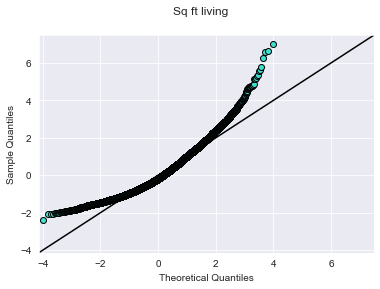

In [140]:
#Just looking at the QQ plots
fig, ax = plt.subplots()
sm.graphics.qqplot(df["sqft_living"], dist=stats.norm, line='45', fit=True,
                   ax=ax)

scatter = ax.lines[0]
line = ax.lines[1]
scatter.set_markeredgecolor("black")
scatter.set_markerfacecolor("turquoise")
line.set_color("black")
fig.suptitle("Sq ft living");

Hmmmmmmmm

In [141]:
#Maybe it's an issue with outliers on the variables? Testing living room area
2410-1370 #sqft_living IQR
no_outlier_lv = df[(df["sqft_living"] < 3450) & 
                   (df["sqft_living"] > 330)].copy()

In [142]:
y = no_outlier_lv["price"]
X_baseline = no_outlier_lv[["sqft_living"]]
baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()
print("outlier-less living room JB test")
print(jarque_bera(baseline_results.resid)[1])

outlier-less living room JB test
0.0


Alright, so nothing has normally distributed residuals. I wonder what could cause that?

### Homoschedasticity

In [143]:
from statsmodels.stats.diagnostic import het_goldfeldquandt

In [144]:
for feat in feats:
    y = df["price"]
    X = df[[feat]]
    linear_model = sm.OLS(y, sm.add_constant(X))
    linear_results = linear_model.fit()
    print(feat)
    print(het_goldfeldquandt(y, X, alternative='two-sided'))
    print("\n")

bedrooms
(0.9891743878554159, 0.5110655890462095, 'two-sided')


bathrooms
(0.9835483165441863, 0.31655708419922834, 'two-sided')


sqft_living
(0.9915652507406674, 0.6090545385444139, 'two-sided')


sqft_patio
(1.0004443777905307, 0.9785999418459354, 'two-sided')


sqft_garage
(0.982649503725694, 0.29062223820481975, 'two-sided')


condition
(0.9929829926538526, 0.6707211920921984, 'two-sided')


grade
(1.0238054572580597, 0.15547867671441595, 'two-sided')




"Grade" was close, but everything passed.

In [145]:
import scipy
for feat in feats:
    print(feat, scipy.stats.kstest(df[feat], 
                    "norm", args = (np.mean(df[feat]), np.std(df[feat]))))

bedrooms KstestResult(statistic=0.2356441631250481, pvalue=0.0)
bathrooms KstestResult(statistic=0.15241724062347806, pvalue=0.0)
sqft_living KstestResult(statistic=0.07387380989963549, pvalue=7.248823650092233e-139)
sqft_patio KstestResult(statistic=0.18496369527764334, pvalue=0.0)
sqft_garage KstestResult(statistic=0.2129547483536784, pvalue=0.0)
condition KstestResult(statistic=0.3717056737731804, pvalue=0.0)
grade KstestResult(statistic=0.30079623538660105, pvalue=0.0)


Great

# Testing other transformations and subsets

## Higher order regressions

In [146]:
#2nd power?
for feat in feats:
    df_quad = df.copy()
    df_quad[feat] = df_quad[feat]**2
    sq_results = sm.OLS(df_quad["price"], #The squared data's results
                             sm.add_constant(df_quad[feat])).fit()
    norm_results = sm.OLS(df["price"], #The original OLS to compare
                             sm.add_constant(df[feat])).fit()
    print(feat)
    print("change from original =", sq_results.rsquared-norm_results.rsquared)
    print("\n")

bedrooms
change from original = -0.010162156495328145


bathrooms
change from original = -0.0025538518203890304


sqft_living
change from original = -0.013876879498876948


sqft_patio
change from original = -0.039393405625060884


sqft_garage
change from original = -0.006099661346317009


condition
change from original = -6.416779921869509e-05


grade
change from original = -0.0023535009906787696




In [147]:
#3rd power?
for feat in feats:
    df_third = df.copy()
    df_third[feat] = df_third[feat]**3
    norm_results = sm.OLS(df["price"], 
                             sm.add_constant(df[feat])).fit() 
    cbd_results = sm.OLS(df_third["price"], 
                         sm.add_constant(df_third[feat])).fit()
    print(feat)
    print("change=", cbd_results.rsquared - norm_results.rsquared)
    print("\n")

bedrooms
change= -0.03525135563589066


bathrooms
change= -0.04477990860548231


sqft_living
change= -0.08112668754173757


sqft_patio
change= -0.0667661592214972


sqft_garage
change= -0.05370167144523619


condition
change= -1.7818655756451918e-05


grade
change= 0.02627087826559571




That didn't improve anything.

## Slicing categorical values?

I'm going to see if things are more significant if we just have houses with certain binary features.

In [148]:
#New dfs for each feature.
waterfront_df = df[df["waterfront"]==1].copy()
greenbelt_df = df[df["greenbelt"]==1].copy()
nuisance_df = df[df["nuisance"]==1].copy()

In [149]:
all_x = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', "waterfront", 'greenbelt', 'nuisance', 'condition', 'grade',
       'sqft_garage', 'sqft_patio', 'yr_built', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'sewer_system_PUBLIC']

waterfront_model = sm.OLS(waterfront_df["price"], sm.add_constant(waterfront_df[all_x]))
waterfront_results = waterfront_model.fit()
print(waterfront_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     15.53
Date:                Fri, 14 Jul 2023   Prob (F-statistic):           3.01e-29
Time:                        12:51:25   Log-Likelihood:                -5320.9
No. Observations:                 364   AIC:                         1.067e+04
Df Residuals:                     349   BIC:                         1.073e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
bedrooms              -2.607e+

Waterfront houses only explain 38% of the variance.

In [150]:
greenbelt_model = sm.OLS(greenbelt_df["price"], sm.add_constant(greenbelt_df[all_x]))
greenbelt_results = greenbelt_model.fit()
print(greenbelt_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     66.35
Date:                Fri, 14 Jul 2023   Prob (F-statistic):          1.51e-124
Time:                        12:51:25   Log-Likelihood:                -10495.
No. Observations:                 735   AIC:                         2.102e+04
Df Residuals:                     719   BIC:                         2.110e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
bedrooms              -7.304e+

Wow
#### If we only look at properties on a greenbelt, we can explain 58 percent of the variability!
(That's may be because there are not many greenbelt homes and they're somewhat similar.)

In [151]:
nuisance_model = sm.OLS(nuisance_df["price"], sm.add_constant(nuisance_df[all_x]))
nuisance_results = nuisance_model.fit()
print(nuisance_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     230.1
Date:                Fri, 14 Jul 2023   Prob (F-statistic):               0.00
Time:                        12:51:25   Log-Likelihood:                -71908.
No. Observations:                5032   AIC:                         1.438e+05
Df Residuals:                    5015   BIC:                         1.440e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
bedrooms              -4.993e+

# Condition and Grade

Building more rooms or living rooms will be impractical. Can we at least give a recommendation to increase the condition and/or grade of the place?

In [152]:
df["condition"].value_counts(sort=False)

0       60
1      225
2    17828
3     7879
4     3174
Name: condition, dtype: int64

In [153]:
df["grade"].value_counts(sort=False)

1     1302
2        1
3        9
4       45
5      381
6     2832
7    11654
8     9316
9     3626
Name: grade, dtype: int64

There are a weird amount of homes with a 2 or 3 grade. Maybe there's a bias in the people who assess homes? Or maybe the system is poorly constructed, such that the qualities needed to be a 2 or 3 aren't reasonable considering the way people/homes are?

### Condition

According to the website condition is related to things like "painted surfaces, roofing, plumbing, and heating".

In [154]:
prev_mean = 0
prev_med = 0
for i in range(5):
    idf = df[df["condition"] == i].copy()
    print(i)
    mean = idf.price.mean()
    med = idf.price.median()
    print((mean/1000).round(1), "= mean in k")
    print((med/1000).round(1), "= median in k")
    print("num of houses", len(idf))
    if i > 0:
        print("change in mean in thousands", ((mean-prev_mean)/1000).round(1))
        print("mean change in %", (((mean-prev_mean)/prev_mean)*100).round(1))
        print("change in median in thousands", ((med-prev_med)/1000).round(1))
        print("median change in %", (((med-prev_med)/prev_med)*100).round(1))
    else:
        pass
    prev_mean = mean
    prev_med = med
    print("\n")

0
596.5 = mean in k
565.0 = median in k
num of houses 60


1
792.5 = mean in k
662.0 = median in k
num of houses 225
change in mean in thousands 196.0
mean change in % 32.9
change in median in thousands 97.0
median change in % 17.2


2
1004.0 = mean in k
850.0 = median in k
num of houses 17828
change in mean in thousands 211.5
mean change in % 26.7
change in median in thousands 188.0
median change in % 28.4


3
980.2 = mean in k
850.0 = median in k
num of houses 7879
change in mean in thousands -23.8
mean change in % -2.4
change in median in thousands 0.0
median change in % 0.0


4
1045.7 = mean in k
890.0 = median in k
num of houses 3174
change in mean in thousands 65.5
mean change in % 6.7
change in median in thousands 40.0
median change in % 4.7




There seems to be a general trend upward at the beginning that peters out.

In [155]:
low_cond_df = df[df["condition"]  < 3].copy()
all_x = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'greenbelt', 'nuisance', 'condition', 'grade',
       'sqft_garage', 'sqft_patio', 'yr_built', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'sewer_system_PUBLIC']
y = low_cond_df["price"]
all_model = sm.OLS(y, sm.add_constant(low_cond_df[all_x]))
all_results = all_model.fit()
print(all_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     784.4
Date:                Fri, 14 Jul 2023   Prob (F-statistic):               0.00
Time:                        12:51:25   Log-Likelihood:            -2.5930e+05
No. Observations:               18113   AIC:                         5.186e+05
Df Residuals:                   18095   BIC:                         5.188e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4.487e+

In [156]:
low_cond_df = df[df["condition"]  < 3].copy()
low_cond_model = sm.OLS(low_cond_df["price"], 
                        sm.add_constant(low_cond_df["condition"]))
low_cond_results = low_cond_model.fit()
print(low_cond_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     71.63
Date:                Fri, 14 Jul 2023   Prob (F-statistic):           2.80e-17
Time:                        12:51:25   Log-Likelihood:            -2.6427e+05
No. Observations:               18113   AIC:                         5.285e+05
Df Residuals:                   18111   BIC:                         5.286e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        5.89e+05   4.87e+04     12.089      0.0

Boo. There was a small uptick in explanatory power in the big model, but condition itself doesn't explain a lot.

### Grade

According to the website, grade means: "Represents the construction quality of improvements"

In [157]:
prev_mean = 0
prev_med = 0
for i in range(9):
    idf = df[df["grade"] == i+1].copy()
    print(i+1)
    mean = idf.price.mean()
    med = idf.price.median()
    print((mean/1000).round(1), "= mean in k")
    print((med/1000).round(1), "= median in k")
    print("num of houses", len(idf))
    if i > 0:
        print("change in mean in thousands", ((mean-prev_mean)/1000).round(1))
        print("mean change in %", (((mean-prev_mean)/prev_mean)*100).round(1))
        print("change in median in thousands", ((med-prev_med)/1000).round(1))
        print("median change in %", (((med-prev_med)/prev_med)*100).round(1))
    else:
        pass
    prev_mean = mean
    prev_med = med
    print("\n")

1
1971.3 = mean in k
2002.5 = median in k
num of houses 1302


2
400.0 = mean in k
400.0 = median in k
num of houses 1
change in mean in thousands -1571.3
mean change in % -79.7
change in median in thousands -1602.5
median change in % -80.0


3
552.4 = mean in k
435.0 = median in k
num of houses 9
change in mean in thousands 152.4
mean change in % 38.1
change in median in thousands 35.0
median change in % 8.8


4
547.4 = mean in k
458.0 = median in k
num of houses 45
change in mean in thousands -5.0
mean change in % -0.9
change in median in thousands 23.0
median change in % 5.3


5
579.7 = mean in k
500.0 = median in k
num of houses 381
change in mean in thousands 32.3
mean change in % 5.9
change in median in thousands 42.0
median change in % 9.2


6
621.3 = mean in k
571.1 = median in k
num of houses 2832
change in mean in thousands 41.6
mean change in % 7.2
change in median in thousands 71.1
median change in % 14.2


7
810.1 = mean in k
745.0 = median in k
num of houses 11654
change 

Wow, we finally found something that makes sense.

Weirdly, there are only ten houses with a grade of 2 or 3. And for some reason, the 1-graded homes are worth more than the highest ones in our whole sample? Let's try this again with those removed.

In [158]:
four_plus_g_df = df[df["grade"] > 3].copy()
all_x = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'greenbelt', 'nuisance', 'condition', 'grade',
       'sqft_garage', 'sqft_patio', 'yr_built', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'sewer_system_PUBLIC']
y = four_plus_g_df["price"]
all_model = sm.OLS(y, sm.add_constant(four_plus_g_df[all_x]))
all_results = all_model.fit()
print(all_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     1219.
Date:                Fri, 14 Jul 2023   Prob (F-statistic):               0.00
Time:                        12:51:25   Log-Likelihood:            -3.9573e+05
No. Observations:               27854   AIC:                         7.915e+05
Df Residuals:                   27836   BIC:                         7.916e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  6.669e+

In [159]:
four_plus_model = sm.OLS(four_plus_g_df["price"], 
                        sm.add_constant(four_plus_g_df["grade"]))
four_plus_results = four_plus_model.fit()
print(four_plus_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     9341.
Date:                Fri, 14 Jul 2023   Prob (F-statistic):               0.00
Time:                        12:51:25   Log-Likelihood:            -3.9945e+05
No. Observations:               27854   AIC:                         7.989e+05
Df Residuals:                   27852   BIC:                         7.989e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.006e+06   2.04e+04    -49.232      0.0

At long last I can breathe a sigh of relief. I found a metric that explains a decent amount of the variability in price that can actually be actionable (unlike building a new bathroom or making a living room bigger).

#### Every uptick in "grade" starting with the change from 3 to 4 accounts for about 200 thousand dollars in the home's value.

Now that I have a metric to look at, let's see if the renovators should tailor their prices/advertising based on some qualities of the home.

## Exploring higher graded homes
We'll only use the homes with a grade of 3 or more for this section.

If the greenbelt_df explains more variability, how much does condition matter when we filter out the low scores for condition in just the greenbelt adjacent homes?

In [160]:
#combining the greenbelt with homes of grade 3 or more
green_grade_df = greenbelt_df[greenbelt_df["grade"] > 3]
all_x = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'greenbelt', 'nuisance', 'condition', 'grade',
       'sqft_garage', 'sqft_patio', 'yr_built', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'sewer_system_PUBLIC']
y = green_grade_df["price"]
all_model = sm.OLS(y, sm.add_constant(green_grade_df[all_x]))
all_results = all_model.fit()
print(all_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     39.80
Date:                Fri, 14 Jul 2023   Prob (F-statistic):           4.07e-79
Time:                        12:51:25   Log-Likelihood:                -8484.7
No. Observations:                 599   AIC:                         1.700e+04
Df Residuals:                     583   BIC:                         1.707e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
bedrooms              -9.145e+

It's still one of the strongest models I have, accounting for over 50% of the price.

In [161]:
len(green_grade_df)

599

#### Every uptick in grade for a greenbelt home accounts for about 175k dollars in the price of a home.
Although it's only for 599 homes, a far cry from the 30,000 homes we have in the large df.

What about waterfront adjacent homes?

In [162]:
#combining the waterfront with homes of grade 3 or more
water_grade_df = waterfront_df[waterfront_df["grade"] > 3]
all_x = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'greenbelt', 'nuisance', 'condition', 'grade',
       'sqft_garage', 'sqft_patio', 'yr_built', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'sewer_system_PUBLIC']
y = water_grade_df["price"]
all_model = sm.OLS(y, sm.add_constant(water_grade_df[all_x]))
all_results = all_model.fit()
print(all_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     12.52
Date:                Fri, 14 Jul 2023   Prob (F-statistic):           2.75e-23
Time:                        12:51:25   Log-Likelihood:                -4836.7
No. Observations:                 332   AIC:                             9703.
Df Residuals:                     317   BIC:                             9760.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
bedrooms              -3.066e+

What about older homes vs newer ones?

In [163]:
four_plus_g_df["yr_built"].describe()

count    27854.000000
mean      1973.885187
std         32.080933
min       1900.000000
25%       1952.000000
50%       1976.000000
75%       2002.000000
max       2022.000000
Name: yr_built, dtype: float64

In [164]:
newest_homes = four_plus_g_df[four_plus_g_df["yr_built"] >= 2002]
newish_homes = four_plus_g_df[(four_plus_g_df["yr_built"] >= 1976) &
                            (four_plus_g_df["yr_built"] < 2002)]
oldish_homes = four_plus_g_df[(four_plus_g_df["yr_built"] >= 1952) &
                           (four_plus_g_df["yr_built"] < 1976)]
oldest_homes = four_plus_g_df[four_plus_g_df["yr_built"] < 1952]

In [165]:
homes = [newest_homes, newish_homes, oldish_homes, oldest_homes]
for home in homes:
    model = sm.OLS(home["price"], 
                        sm.add_constant(home[all_x]))
    results = model.fit()
    print(home["yr_built"].min(), "to", home["yr_built"].max(),
          "\n", len(home), "number of homes", results.summary())
    print("\n \n")

2002 to 2022 
 7121 number of homes                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     376.3
Date:                Fri, 14 Jul 2023   Prob (F-statistic):               0.00
Time:                        12:51:25   Log-Likelihood:            -1.0095e+05
No. Observations:                7121   AIC:                         2.019e+05
Df Residuals:                    7103   BIC:                         2.021e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

The oldest homes are a little less affected, but overall the pattern holds.

And what about by price?

In [166]:
four_plus_g_df["price"].describe()

count    2.785400e+04
mean     9.543740e+05
std      4.728969e+05
min      2.736000e+04
25%      6.300000e+05
50%      8.250000e+05
75%      1.191056e+06
max      2.900000e+06
Name: price, dtype: float64

In [167]:
top_homes = four_plus_g_df[four_plus_g_df["price"] >= 1191000]
upper_homes = four_plus_g_df[(four_plus_g_df["price"] >= 825000) &
                            (four_plus_g_df["price"] < 1191000)]
lower_homes = four_plus_g_df[(four_plus_g_df["price"] >= 630000) &
                           (four_plus_g_df["price"] < 825000)]
bottom_homes = four_plus_g_df[four_plus_g_df["price"] < 630000]

In [168]:
homes = [top_homes, upper_homes, lower_homes, bottom_homes]
for home in homes:
    model = sm.OLS(home["price"], 
                        sm.add_constant(home[all_x]))
    results = model.fit()
    print(home["price"].min(), "to", home["price"].max(),
          "\n", len(home), "number of homes", results.summary())
    print("\n \n")

1191000.0 to 2900000.0 
 6967 number of homes                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     94.98
Date:                Fri, 14 Jul 2023   Prob (F-statistic):          5.31e-299
Time:                        12:51:25   Log-Likelihood:                -98765.
No. Observations:                6967   AIC:                         1.976e+05
Df Residuals:                    6949   BIC:                         1.977e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

strong multicollinearity or other numerical problems.

 

27360.0 to 629999.0 
 6932 number of homes                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     27.78
Date:                Fri, 14 Jul 2023   Prob (F-statistic):           1.87e-86
Time:                        12:51:25   Log-Likelihood:                -90575.
No. Observations:                6932   AIC:                         1.812e+05
Df Residuals:                    6914   BIC:                         1.813e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------

All of these models are hot garbage, I shouldn't take any information from these. What a surprise. The dataset did not like being drawn and quartered.

# Conclusion

## Model summary
My final model, built off of the four_plus_g_df, was able to explain 42.7% of the variability in homes' prices. This dataframe is the result after excluding homes whose values were more than 2 standard deviations above the mean, as well as excluding homes who had a "grade" of 3 or less. The first exclusion was in an effort to remove outliers, the second exclusion was to avoid multiple some oddities seen in the lower grade range. Ultimately, this means that the predictive power of this model is untested for homes that are valued over about 2 million dollars.

I tested various subsets of data, and was able to discover a model that explained just over 50% of the variability in price. Unfortunately this covered only the ~600 homes with the "greenbelt" label.

## Recommendation to Stakeholder
Excluding the currently inexplicable prices for homes with low conditions, it seems as though we can advise our renovation company that they should emphasize improving "condition". Every bump up in its score seems to correlate with a 200 thousand dollar increase in the value of a home.

If it's feasible to do so, a bathroom installation would increase the value of a home potentially by 73,000 dollars.

## Next Steps
Find out what causes the grade to be increased! The King's County website was unclear.

To improve everyone's understanding of Kings County, improvements should be taken to determine what is causing this glut of homes with a condition of 1, and this dearth of homes with a condition of 2 and 3.

Also, all of the models still could explain only but so much. The renovators should try and get their hands on some location data more useful than latitude and longitude, such as Zip Code for next time.

I could have improved the information on bathrooms if I checked the price change from a whole number of bathrooms to an additional half-bathroom as well.